## 0. Configurations

In [1]:
# ====================================================================
# Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함
import os  # 디렉토리, 파일 경로 조작 등

import torch
import numpy as np

from pathlib import Path

import albumentations as A
import cv2  # OpenCV - 고급 이미지/비디오 처리
import torch
from torch.utils.data import Dataset  # 커스텀 데이터셋, 배치 로딩
import pandas as pd
from collections import defaultdict, Counter
import os
import json
from tqdm import tqdm
import shutil # 파일 복사/이동
from PIL import Image
from sklearn.model_selection import train_test_split
import random

# YOLOv8 라이브러리
from ultralytics import YOLO

# yaml 라이브러리
import yaml 

# Garbage Collector 모듈
import gc

from torchmetrics.detection.mean_ap import MeanAveragePrecision

# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화
import matplotlib
# 한글 폰트 설정 (Windows의 기본 한글 폰트)
matplotlib.rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.patches as patches

# 주피터 노트북에서 이미지 인라인 표시를 위한 매직 명령어 추가 (여기 추가)
%matplotlib inline

# 메모리 정리 루틴
gc.collect()
torch.cuda.empty_cache()


# --- 디바이스 설정 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

# --- 학습 하이퍼파라미터 ---
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# --- 데이터 경로 설정 ---
# DATA_ROOT = path
# DATA_ROOT = "data/raw/ai03-level1-project/"  # 경로
# TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "train_images")
# TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, "train_annotations")
# TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test_images")
# PROCESSED_TRAIN_CSV = "../data/processed/train_df.csv"  # 데이터 전처리된 csv 파일

# --- 모델 설정 ---
NUM_CLASSES = 73
MODEL_NAME = "fasterrcnn_resnet50_fpn"
USE_PRETRAINED = True

# --- 학습 고도화 설정 ---
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# --- 실험 로깅용 설정 ---
USE_WANDB = True
WANDB_PROJECT = "AI03-Project-1"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"


# --- 실험 결과 저장 경로 ---
EXPERIMENT_DIR = "../experiments"

## 1. Data-preprocessing

### Fast-rcnn

In [2]:
def parse_raw_annotations(ann_dir: Path) -> pd.DataFrame:
    """
    복잡한 3중 폴더 구조의 원본 어노테이션을 파싱하여
    하나의 Pandas DataFrame으로 반환하는 함수.
    """
    all_annotations = []

    # Level 1: 이미지별 폴더 순회
    image_level_dirs = os.listdir(ann_dir)
    for image_dir_name in tqdm(image_level_dirs, desc="[L1] Images"):
        image_dir_path = ann_dir / image_dir_name
        if not image_dir_path.is_dir():
            continue

        # Level 2: 알약 종류 폴더 순회
        pill_level_dirs = os.listdir(image_dir_path)
        for pill_dir_name in pill_level_dirs:
            pill_dir_path = image_dir_path / pill_dir_name
            if not pill_dir_path.is_dir():
                continue

            # Level 3: 실제 .json 파일 파싱
            json_files = [f for f in os.listdir(pill_dir_path) if f.endswith(".json")]
            if not json_files:
                continue

            # 첫 번째 json 파일만 사용
            json_file_path = pill_dir_path / json_files[0]

            try:
                with open(json_file_path, "r", encoding="utf-8") as f:
                    ann_data = json.load(f)

                    image_info = ann_data.get("images", [{}])[0]
                    annotation_info = ann_data.get("annotations", [{}])[0]
                    category_info = ann_data.get("categories", [{}])[0]

                    all_annotations.append(
                        {
                            "image_id": image_info.get("id"),
                            "file_name": image_info.get("file_name"),
                            "width": image_info.get("width"),
                            "height": image_info.get("height"),
                            "category_id": category_info.get("id"),
                            "class_name": category_info.get("name"),
                            "bbox": annotation_info.get("bbox"),
                        }
                    )
            except Exception as e:
                print(f"\n파일 처리 에러: {json_file_path}, 에러: {e}")

    return pd.DataFrame(all_annotations)

In [3]:
# 1. 핵심 함수를 호출해서 DataFrame 생성

BASE_DIR = Path("../")  # 상대경로
RAW_DATA_DIR = BASE_DIR / "data/raw/"
PROCESSED_DATA_DIR = BASE_DIR / "data/processed"

TRAIN_IMAGE_DIR = RAW_DATA_DIR / "train_images"
TRAIN_ANNO_DIR = RAW_DATA_DIR / "train_annotations"
TEST_IMAGE_DIR = RAW_DATA_DIR / "test_images"
SAVE_PATH = PROCESSED_DATA_DIR / "train_df.csv"
train_df = parse_raw_annotations(TRAIN_ANNO_DIR)

# --- (1). bbox 컬럼을 4개로 분리 ---
# bbox 컬럼 분리
bbox_df = pd.DataFrame(
    train_df["bbox"].tolist(), columns=["bbox_x", "bbox_y", "bbox_w", "bbox_h"]
)
train_df = pd.concat([train_df.drop("bbox", axis=1), bbox_df], axis=1)

# ✨ --- [핵심 수정] 잘못된 바운딩 박스 데이터 제거 ---
# xmax (bbox_x + bbox_w)가 이미지 너비(width)를 초과하는 경우
invalid_x = train_df["bbox_x"] + train_df["bbox_w"] > train_df["width"]
# ymax (bbox_y + bbox_h)가 이미지 높이(height)를 초과하는 경우
invalid_y = train_df["bbox_y"] + train_df["bbox_h"] > train_df["height"]

# 잘못된 데이터를 필터링
invalid_rows = train_df[invalid_x | invalid_y]
if not invalid_rows.empty:
    print(f"--- {len(invalid_rows)}개의 잘못된 바운딩 박스 데이터를 찾았습니다. ---")
    print(
        invalid_rows[
            ["file_name", "width", "height", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]
        ]
    )

    # 유효한 데이터만 남김
    train_df = train_df[~(invalid_x | invalid_y)]
    print(f"\n잘못된 데이터를 제거하고, {len(train_df)}개의 데이터만 사용합니다.")

# --- (2). category_id를 새로운 label_idx로 매핑 ---
# 고유한 category_id 목록을 뽑아 정렬
unique_category_ids = sorted(train_df["category_id"].unique())
NUM_CLASSES = len(unique_category_ids)
# category_id를 0, 1, 2... 인덱스로 변환하는 딕셔너리 생성
id_to_idx = {
    int(original_id): idx
    for idx, original_id in enumerate(
        unique_category_ids, start=1
    )  # <--- start=1 추가!
}
# 이 매핑 정보를 사용해서 'label_idx'라는 새 컬럼을 추가
train_df["label_idx"] = train_df["category_id"].map(id_to_idx)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)


# 나중에 추론 결과에서 원래 클래스 이름을 찾을 수 있도록 매핑 정보도 저장
label_map = {
    "id_to_idx": id_to_idx,
    "idx_to_id": {idx: int(original_id) for original_id, idx in id_to_idx.items()},
    "id_to_name": dict(zip(train_df["category_id"], train_df["class_name"])),
}
with open(PROCESSED_DATA_DIR / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)

print(f"\n총 {len(unique_category_ids)}개의 고유 클래스를 발견했습니다.")
print("라벨 매핑 정보를 'data/processed/label_map.json'에 저장했습니다.")


# 3. 최종 DataFrame을 CSV 파일로 저장
train_df.to_csv(SAVE_PATH, index=False)

print(f"\n--- 데이터 전처리 및 저장 완료! ---")
print(train_df.head())

[L1] Images: 100%|██████████| 498/498 [00:00<00:00, 592.40it/s]

--- 1개의 잘못된 바운딩 박스 데이터를 찾았습니다. ---
                                              file_name  width  height  \
1721  K-003544-004543-012247-016551_0_2_0_2_70_000_2...    976    1280   

      bbox_x  bbox_y  bbox_w  bbox_h  
1721     653    8889     217     217  

잘못된 데이터를 제거하고, 1875개의 데이터만 사용합니다.

총 73개의 고유 클래스를 발견했습니다.
라벨 매핑 정보를 'data/processed/label_map.json'에 저장했습니다.

--- 데이터 전처리 및 저장 완료! ---
   image_id                                          file_name  width  height  \
0      1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...    976    1280   
1      1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...    976    1280   
2      1417  K-001900-010224-016551-031705_0_2_0_2_70_000_2...    976    1280   
3       411  K-001900-010224-016551-033009_0_2_0_2_70_000_2...    976    1280   
4       409  K-001900-010224-016551-033009_0_2_0_2_75_000_2...    976    1280   

   category_id     class_name  bbox_x  bbox_y  bbox_w  bbox_h  label_idx  
0         1899     보령부스파정 5mg     645   

<Axes: xlabel='label_idx'>

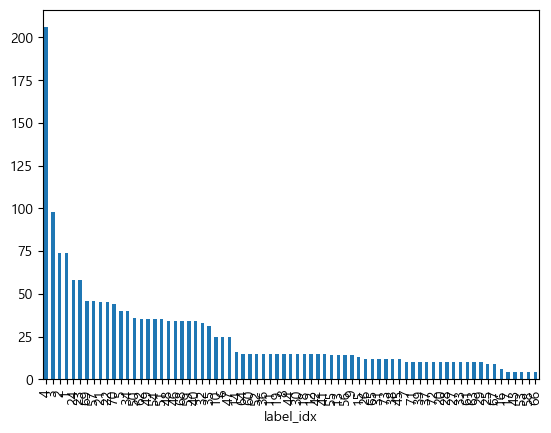

In [4]:
train_df["label_idx"].value_counts().plot(kind="bar")

In [5]:
train_df["class_name"].value_counts()

class_name
기넥신에프정(은행엽엑스)(수출용)    206
일양하이트린정 2mg            98
뮤테란캡슐 100mg            74
보령부스파정 5mg             74
동아가바펜틴정 800mg          58
                     ... 
자이프렉사정 2.5mg            4
쿠에타핀정 25mg              4
졸로푸트정 100mg             4
렉사프로정 15mg              4
브린텔릭스정 20mg             4
Name: count, Length: 73, dtype: int64

In [6]:
classes_tmp = train_df["class_name"].unique()
classes_tmp

array(['보령부스파정 5mg', '동아가바펜틴정 800mg', '낙소졸정 500/20mg', '신바로정', '가바토파정 100mg', '란스톤엘에프디티정 30mg', '펠루비정(펠루비프로펜)', '울트라셋이알서방정', '비모보정 500/20mg', '레일라정', '스토가정 10mg', '라비에트정 20mg', '놀텍정 10mg', '에스원엠프정 20mg', '케이캡정 50mg', '뮤테란캡슐 100mg', '알드린정', '타이레놀정500mg', '삐콤씨에프정 618.6mg/병', '다보타민큐정 10mg/병', '트루비타정 60mg/병',
       '메가파워정 90mg/병', '비타비백정 100mg/병', '타이레놀이알서방정(아세트아미노펜)(수출용)', '리렉스펜정 300mg/PTP', '써스펜8시간이알서방정 650mg', '맥시부펜이알정 300mg', '삼남건조수산화알루미늄겔정', '큐시드정 31.5mg/PTP', '일양하이트린정 2mg', '뉴로메드정(옥시라세탐)', '리피토정 20mg', '크레스토정 20mg', '오마코연질캡슐(오메가-3-산에틸에스테르90)', '플라빅스정 75mg', '아토르바정 10mg', '리피로우정 20mg', '리바로정 4mg', '아토젯정 10/40mg',
       '로수젯정10/5밀리그램', '로수바미브정 10/20mg', '에빅사정(메만틴염산염)(비매품)', '리리카캡슐 150mg', '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '콜리네이트연질캡슐 400mg', '마도파정', '아질렉트정(라사길린메실산염)', '글리아타민연질캡슐', '글리틴정(콜린알포세레이트)', '카발린캡슐 25mg', '기넥신에프정(은행엽엑스)(수출용)', '노바스크정 5mg', '자누비아정 50mg', '트라젠타정(리나글립틴)', '트라젠타듀오정 2.5/850mg', '자누메트엑스알서방정 100/1000mg',
       '제미메트서방정 50/1000mg', '엑스포지정 5/160mg', '자누메트정 50/850mg', '아모잘탄

In [7]:
# 1. 'category_id'와 'class_name' 컬럼으로 고유한 쌍을 찾고, ID 기준으로 정렬
class_mapping_df = (
    train_df[["category_id", "class_name"]]
    .drop_duplicates()
    .sort_values(by="category_id")
)
# 2. 정렬된 DataFrame에서 클래스 이름만 리스트로 추출
sorted_class_names = [
    name.split("(")[0].strip() for name in class_mapping_df["class_name"]
]
# 3. 맨 앞에 'background' 추가
classes = ["background"] + sorted_class_names

print(f"총 클래스 개수 (배경 포함): {len(classes)}")
print(f"클래스 리스트: {classes}")

총 클래스 개수 (배경 포함): 74
클래스 리스트: ['background', '보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정', '무코스타정', '알드린정', '뉴로메드정', '타이레놀정500mg', '에어탈정', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.5mg/PTP', '아모잘탄정 5/100mg', '세비카정 10/40mg', '트윈스타정 40/5mg', '카나브정 60mg', '울트라셋이알서방정', '졸로푸트정 100mg', '트라젠타정', '비모보정 500/20mg', '레일라정', '리바로정 4mg', '렉사프로정 15mg', '트라젠타듀오정 2.5/850mg', '낙소졸정 500/20mg', '아질렉트정', '자누메트엑스알서방정 100/1000mg', '글리아타민연질캡슐', '신바로정', '에스원엠프정 20mg', '브린텔릭스정 20mg', '글리틴정', '제

### Yolov8

In [8]:
PROJECT_ROOT = Path("../../AI03-Project-1")
DATA_ROOT = Path("../../AI03-Project-1/data/raw") # 실제 데이터 경로로 변경 필요
train_image_dir = DATA_ROOT / "train_images"
train_ann_path = DATA_ROOT / "train_annotations"
test_image_dir = DATA_ROOT / "test_images"

In [9]:
# YOLOv8 데이터를 저장할 새 디렉토리
YOLO_DATA_ROOT = Path("../../AI03-Project-1/data") / "processed" / "yolov8_dataset"
YOLO_IMAGES_TRAIN = YOLO_DATA_ROOT / "images" / "train"
YOLO_LABELS_TRAIN = YOLO_DATA_ROOT / "labels" / "train"
YOLO_IMAGES_VAL = YOLO_DATA_ROOT / "images" / "val"
YOLO_LABELS_VAL = YOLO_DATA_ROOT / "labels" / "val"
YOLO_LABELS_TEMP = Path("/Users/user/myproject/AI03-Project-1/data") / "processed" / "yolo_labels_temp" # 변환된 .txt 파일을 임시로 저장할 곳

In [10]:
# 디렉토리 생성
os.makedirs(YOLO_IMAGES_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_TEMP, exist_ok=True)

In [11]:
def create_yolo_annotations_and_map(annotation_root: Path, train_image_dir: Path, yolo_labels_output_dir: Path):
    """
    제공된 복잡한 JSON 어노테이션 폴더 구조를 파싱하고 YOLO 형식(.txt)으로 변환하여 저장합니다.
    - train_images: 이미지 파일들 (예: K-XXXXX_Y_Z.png)
    - train_annotations:
        - K-XXXXX_Y_Z_json/ (이미지 그룹 폴더)
            - K-AAAAA/ (개별 약제 ID 폴더)
                - K-XXXXX_Y_Z.json (해당 이미지 내 K-AAAAA 약제의 어노테이션)

    각 이미지에 대한 어노테이션이 여러 JSON 파일(각 알약별)에 분산되어 있으므로
    JSON 파일명이 원본 이미지 파일명과 동일한 형태를 처리합니다.
    """
    
    category_id_to_name = {}
    
    # 1. 모든 JSON 파일을 스캔하여 category_id_to_name 맵 수집
    # 모든 JSON 파일에서 클래스 정보를 한 번에 수집합니다.
    all_json_paths_for_categories_scan = []
    for dirpath, _, filenames in os.walk(annotation_root):
        for fname in filenames:
            if fname.endswith('.json'):
                all_json_paths_for_categories_scan.append(os.path.join(dirpath, fname))

    print(f"Scanning {len(all_json_paths_for_categories_scan)} JSON files to collect categories...")
    
    for json_path in tqdm(all_json_paths_for_categories_scan, desc="Collecting categories"):
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if 'categories' in data:
                    for cat in data['categories']:
                        category_id_to_name[cat['id']] = cat['name']
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Warning: Could not parse categories from {json_path} due to {e}. Skipping.")
            continue

    sorted_category_ids = sorted(list(category_id_to_name.keys()))
    yolo_class_id_map = {cat_id: idx for idx, cat_id in enumerate(sorted_category_ids)}
    yolo_idx_to_name_map = {idx: category_id_to_name[cat_id] for cat_id, idx in yolo_class_id_map.items()}

    print(f"\nDetected {len(sorted_category_ids)} unique categories.")
    
    for cat_id in sorted_category_ids:
        print(f"  Original ID: {cat_id}, YOLO ID: {yolo_class_id_map[cat_id]}, Name: {category_id_to_name[cat_id]}")

    # 2. train_images 폴더의 모든 이미지 파일 목록을 확보
    all_image_files_in_dir = []
    # 이미지 확장자들을 유연하게 처리
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']: 
        all_image_files_in_dir.extend(list(train_image_dir.glob(f"*{ext}")))
    all_image_files_in_dir = sorted(list(set(all_image_files_in_dir))) # 중복 제거 및 정렬
    
    print(f"\nFound {len(all_image_files_in_dir)} image files in {train_image_dir}")

    # YOLO 라벨을 저장할 임시 디렉토리 생성
    yolo_labels_output_dir.mkdir(parents=True, exist_ok=True)

    annotations_info = defaultdict(dict) # 각 이미지에 대한 정보를 저장

    # 3. 각 이미지 파일에 대해 해당 이미지의 모든 알약 JSON 어노테이션을 찾아 YOLO 형식으로 변환
    processed_json_count = 0
    generated_yolo_labels_count = 0

    for img_path in tqdm(all_image_files_in_dir, desc="Processing images and consolidating annotations"):
        img_stem = img_path.stem # 예: 'K-001900-010224-016551-031705_0_2_0_2_70_000_200'

        try:
            with Image.open(img_path) as img:
                img_w, img_h = img.size
        except Exception as e:
            print(f"Error opening image {img_path}: {e}. Skipping this image.")
            continue
        
        yolo_lines_for_this_image = []
        found_ann_for_current_image = False # 현재 이미지에 대해 유효한 어노테이션을 찾았는지 여부
        
        # annotation_root 아래의 모든 JSON 파일을 재귀적으로 탐색
        # JSON 파일명이 현재 이미지의 stem과 정확히 일치하는 파일을 찾음
        for dirpath, _, filenames in os.walk(annotation_root):
            for fname in filenames:
                # JSON 파일명이 현재 이미지 파일명(확장자 제외)과 일치하는지 확인
                if fname.endswith('.json') and Path(fname).stem == img_stem:
                    json_file_path = Path(dirpath) / fname
                    
                    try:
                        with open(json_file_path, 'r', encoding='utf-8') as f:
                            ann_data = json.load(f)
                        processed_json_count += 1

                        # JSON 내의 bbox, category_id 추출
                        # 각 JSON 파일은 단 하나의 'annotation' 객체를 포함하거나, 'annotations' 리스트가 있다면 그 리스트의 첫 번째 항목만 유효한 것으로 간주
                        # JSON 구조는 {"annotations": [{"bbox": [...], "category_id": ...}], ...}
                        
                        if 'annotations' in ann_data and ann_data['annotations']: # 어노테이션이 실제로 있는지를 먼저 확인하는 조건
                            for ann in ann_data['annotations']: # 여러 바운딩 박스가 있을 수도 있으니 반복
                                if 'bbox' in ann and 'category_id' in ann: # bbox와 category_id 모두 존재하는 경우에 처리
                                    x, y, w, h = ann['bbox'] # COCO format: [x_min, y_min, width, height]
                                    original_category_id = ann['category_id']

                                    # 바운딩 박스 유효성 검사 및 클리핑 (이미지 경계를 벗어나지 않도록)
                                    x1 = max(0, int(x)) # 음수 방지
                                    y1 = max(0, int(y)) # 음수 방지
                                    x2 = min(int(x + w), img_w) # 우하단 x좌표 (이미지 폭 초과 방지)
                                    y2 = min(int(y + h), img_h) # 우하단 y좌표 (이미지 높이 초과 방지)

                                    if x2 <= x1 or y2 <= y1: # 유효하지 않은 바운딩 박스는 건너뜀
                                        print(f"Warning: Invalid bbox {ann['bbox']} in {json_file_path}. Skipping.")
                                        continue

                                    # YOLO 형식으로 변환: [center_x, center_y, width, height] 정규화
                                    norm_center_x = ((x1 + x2) / 2) / img_w
                                    norm_center_y = ((y1 + y2) / 2) / img_h
                                    norm_width = (x2 - x1) / img_w
                                    norm_height = (y2 - y1) / img_h
                                    
                                    # 클래스 ID 매핑
                                    if original_category_id in yolo_class_id_map:
                                        yolo_class_id = yolo_class_id_map[original_category_id]
                                        yolo_lines_for_this_image.append(
                                            f"{yolo_class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}" # .6f는 YOLO 형식에서 권장되는 정도의 정밀도
                                        )
                                        found_ann_for_current_image = True # 해당 이미지의 라벨 txt 파일 저장 여부를 판단하는 데 사용
                                    else:
                                        print(f"Warning: Original category ID {original_category_id} not found in collected categories for {json_file_path}. Skipping this annotation.") # 매핑이 안 되어 있는 클래스 ID가 있을 경우, 그 바운딩 박스는 건너뜀
                                else:
                                    print(f"Warning: Annotation in {json_file_path} missing 'bbox' or 'category_id'. Skipping.") # 어노테이션(ann) 안에 'bbox' 또는 'category_id' 키가 없으면 건너뜀.
                        
                    except json.JSONDecodeError as e: # JSON 형식 자체가 잘못되었을 때 발생
                        print(f"Error decoding JSON {json_file_path}: {e}. Skipping.") 
                    except KeyError as e: # 'annotations'나 'images' 키가 누락된 JSON 구조일 때 발생
                        print(f"KeyError in JSON {json_file_path}: {e}. Skipping. (Missing expected keys in annotation structure?)")
                    except Exception as e: # 위의 예외들 외에 발생할 수 있는 모든 예외에 대한 포괄적인 처리(타입 변환 실패, 리스트 인덱스 오류)
                        print(f"Unexpected error processing JSON {json_file_path}: {e}. Skipping.")

        # 모든 관련 JSON을 처리한 후, 현재 이미지에 대한 YOLO 어노테이션 파일 저장
        output_txt_filename = img_stem + ".txt" # .txt 파일 생성
        output_txt_path = yolo_labels_output_dir / output_txt_filename # 경로 지정

        if found_ann_for_current_image: # 하나 이상의 유효한 어노테이션을 찾은 경우만 .txt를 저장, 의미 없는 빈 .txt 파일 생성을 방지
            with open(output_txt_path, 'w', encoding='utf-8') as f: # output_txt_path 경로에 .txt 파일을 쓰기 모드('w')로 열고,
                f.write('\n'.join(yolo_lines_for_this_image)) # yolo_lines_for_this_image 리스트(각 줄은 "class_id cx cy w h" 형식)를 줄바꿈으로 이어서 저장.
            
            # annotations_info에는 성공적으로 라벨링된 이미지 정보만 저장
            annotations_info[img_path.name] = { 
                'yolo_label_path': output_txt_path,
                'image_path': img_path
            }
            generated_yolo_labels_count += 1
        else:
            # 이 이미지를 위한 유효한 어노테이션이 하나도 발견되지 않은 경우
            print(f"Warning: No valid annotations found for image {img_path.name}. Skipping label creation for this image.")


    print(f"\n--- Annotation Processing Summary ---")
    print(f"Total JSON files processed: {processed_json_count}")
    print(f"Total YOLO label files generated: {generated_yolo_labels_count}")
    print(f"YOLO format annotations saved to: {yolo_labels_output_dir}")
    return annotations_info, yolo_class_id_map, yolo_idx_to_name_map

In [12]:
# yolo 어노테이션 파일 생성 실행
annotations_info, yolo_class_id_map, yolo_idx_to_name_map = create_yolo_annotations_and_map(
    TRAIN_ANNO_DIR, TRAIN_IMAGE_DIR, YOLO_LABELS_TEMP
)

Scanning 4526 JSON files to collect categories...



Detected 73 unique categories.
  Original ID: 1899, YOLO ID: 0, Name: 보령부스파정 5mg
  Original ID: 2482, YOLO ID: 1, Name: 뮤테란캡슐 100mg
  Original ID: 3350, YOLO ID: 2, Name: 일양하이트린정 2mg
  Original ID: 3482, YOLO ID: 3, Name: 기넥신에프정(은행엽엑스)(수출용)
  Original ID: 3543, YOLO ID: 4, Name: 무코스타정(레바미피드)(비매품)
  Original ID: 3742, YOLO ID: 5, Name: 알드린정
  Original ID: 3831, YOLO ID: 6, Name: 뉴로메드정(옥시라세탐)
  Original ID: 4377, YOLO ID: 7, Name: 타이레놀정500mg
  Original ID: 4542, YOLO ID: 8, Name: 에어탈정(아세클로페낙)
  Original ID: 5093, YOLO ID: 9, Name: 삼남건조수산화알루미늄겔정
  Original ID: 5885, YOLO ID: 10, Name: 타이레놀이알서방정(아세트아미노펜)(수출용)
  Original ID: 6191, YOLO ID: 11, Name: 삐콤씨에프정 618.6mg/병
  Original ID: 6562, YOLO ID: 12, Name: 조인스정 200mg
  Original ID: 10220, YOLO ID: 13, Name: 쎄로켈정 100mg
  Original ID: 12080, YOLO ID: 14, Name: 리렉스펜정 300mg/PTP
  Original ID: 12246, YOLO ID: 15, Name: 아빌리파이정 10mg
  Original ID: 12419, YOLO ID: 16, Name: 자이프렉사정 2.5mg
  Original ID: 12777, YOLO ID: 17, Name: 다보타민큐정 10mg/병
  Origi

Processing images and consolidating annotations:  36%|███▌      | 534/1489 [00:42<01:15, 12.60it/s]

Processing images and consolidating annotations:  92%|█████████▏| 1375/1489 [02:17<00:09, 12.51it/s]

Processing images and consolidating annotations: 100%|██████████| 1489/1489 [02:39<00:00,  9.36it/s]


--- Annotation Processing Summary ---
Total JSON files processed: 4526
Total YOLO label files generated: 1489
YOLO format annotations saved to: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp


In [13]:
# 학습/검증 분할
all_image_filenames = list(annotations_info.keys())
train_img_files, val_img_files = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

print(f"Total images for training/validation: {len(all_image_filenames)}")
print(f"Train images: {len(train_img_files)}")
print(f"Validation images: {len(val_img_files)}")

Total images for training/validation: 1489
Train images: 1191
Validation images: 298


In [14]:
# 데이터셋 디렉토리로 파일 복사
print("Copying files to YOLOv8 dataset structure...\n")

# Train 데이터 복사
for img_file in tqdm(train_img_files, desc="Copying train data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_TRAIN / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_TRAIN / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for train set.")

# Validation 데이터 복사
for img_file in tqdm(val_img_files, desc="Copying validation data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_VAL / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_VAL / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for validation set.")

print("\nData organized for YOLOv8 training.")

Copying files to YOLOv8 dataset structure...



Copying validation data: 100%|██████████| 298/298 [00:03<00:00, 79.56it/s] 


Data organized for YOLOv8 training.


In [15]:
data_yaml_content = {
    'path': str(YOLO_DATA_ROOT),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(yolo_idx_to_name_map),
    'names': {idx: name for idx, name in sorted(yolo_idx_to_name_map.items())} 
}

data_yaml_path = YOLO_DATA_ROOT / "data.yaml"

with open(data_yaml_path, 'w', encoding='utf-8') as f: # 파일 인코딩을 utf-8로 지정
    yaml.dump(data_yaml_content, f, 
              allow_unicode=True,
              sort_keys=False)

print(f"'data.yaml' created at: {data_yaml_path}")
# 생성된 YAML 파일 내용을 확인
with open(data_yaml_path, 'r', encoding='utf-8') as f: 
    print(f.read())

'data.yaml' created at: ..\..\AI03-Project-1\data\processed\yolov8_dataset\data.yaml
path: ..\..\AI03-Project-1\data\processed\yolov8_dataset
train: images/train
val: images/val
nc: 73
names:
  0: 보령부스파정 5mg
  1: 뮤테란캡슐 100mg
  2: 일양하이트린정 2mg
  3: 기넥신에프정(은행엽엑스)(수출용)
  4: 무코스타정(레바미피드)(비매품)
  5: 알드린정
  6: 뉴로메드정(옥시라세탐)
  7: 타이레놀정500mg
  8: 에어탈정(아세클로페낙)
  9: 삼남건조수산화알루미늄겔정
  10: 타이레놀이알서방정(아세트아미노펜)(수출용)
  11: 삐콤씨에프정 618.6mg/병
  12: 조인스정 200mg
  13: 쎄로켈정 100mg
  14: 리렉스펜정 300mg/PTP
  15: 아빌리파이정 10mg
  16: 자이프렉사정 2.5mg
  17: 다보타민큐정 10mg/병
  18: 써스펜8시간이알서방정 650mg
  19: 에빅사정(메만틴염산염)(비매품)
  20: 리피토정 20mg
  21: 크레스토정 20mg
  22: 가바토파정 100mg
  23: 동아가바펜틴정 800mg
  24: 오마코연질캡슐(오메가-3-산에틸에스테르90)
  25: 란스톤엘에프디티정 30mg
  26: 리리카캡슐 150mg
  27: 종근당글리아티린연질캡슐(콜린알포세레이트) 
  28: 콜리네이트연질캡슐 400mg
  29: 트루비타정 60mg/병
  30: 스토가정 10mg
  31: 노바스크정 5mg
  32: 마도파정
  33: 플라빅스정 75mg
  34: 엑스포지정 5/160mg
  35: 펠루비정(펠루비프로펜)
  36: 아토르바정 10mg
  37: 라비에트정 20mg
  38: 리피로우정 20mg
  39: 자누비아정 50mg
  40: 맥시부펜이알정 300mg
  41: 메가파워정 90mg/

## 2. Load a model

### fast-rcnn

In [16]:
# (1) 데이터 증강 (Augmentation) : Albumentations 라이브러리 사용
train_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # PyTorch 텐서로 변환
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)  # bbox 형식은 pascal_voc: [xmin, ymin, xmax, ymax]

val_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="albumentations", label_fields=["labels"]),
)

test_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ]
)


# DataLoader를 위한 collate_fn. 이미지와 타겟을 리스트로 묶어줌
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
class PillDataset(Dataset):
    # --- mode 파라미터 추가 및 df를 직접 받도록 수정 ---
    def __init__(self, df, image_dir, mode="train", transforms=None):
        self.df = df
        self.image_dir = Path(image_dir)
        self.mode = mode
        self.transforms = transforms

        # --- image_ids를 미리 뽑아 중복을 제거 ---
        # df['file_name']을 사용하면 이미지 파일 이름으로 고유한 이미지를 식별 가능.
        self.image_ids = self.df["file_name"].unique()

    def __len__(self):
        # --- 고유한 이미지의 개수를 반환 ---
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_dir / image_id

        image = cv2.imread(str(image_path))
        if image is None:
            raise FileNotFoundError(
                f"Error: Could not load image at path: {image_path}"
            )

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.mode in ["train", "val"]:
            records = self.df[self.df["file_name"] == image_id]
            boxes = records[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values

            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            labels = records["label_idx"].values

            # print(f"\n[DEBUG 1] Image: {image_id}, Original Pixel Coords:\n{boxes}")

            # 바운딩 박스 좌표 정규화
            boxes = boxes.astype(np.float32)
            boxes[:, [0, 2]] /= w
            boxes[:, [1, 3]] /= h

            # print(f"[DEBUG 2] Normalized Coords for Albumentations:\n{boxes}")

            if self.transforms:
                try:
                    transformed = self.transforms(
                        image=image, bboxes=boxes, labels=labels
                    )
                    image = transformed["image"]
                    boxes = transformed["bboxes"]
                    labels = transformed["labels"]
                except Exception as e:
                    print(f"!!!!!!!!!!!!!! Albumentations에서 에러 발생 !!!!!!!!!!!!!!")
                    print(f"Image: {image_id}")
                    print(f"Boxes sent to transform: {boxes}")
                    # raise e  # 에러를 다시 발생시켜서 멈추게 함

            # ... 이하 코드는 이전과 동일 ...
            _, new_h, new_w = image.shape
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            if len(boxes) > 0:
                boxes[:, [0, 2]] *= new_w
                boxes[:, [1, 3]] *= new_h

            target = {
                "boxes": boxes,
                "labels": torch.as_tensor(labels, dtype=torch.int64),
            }

            if len(target["boxes"]) == 0:
                target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
                target["labels"] = torch.zeros((0,), dtype=torch.int64)

            return image, target

            # 테스트 모드일 경우, 이미지와 파일 이름만 반환
        elif self.mode == "test":
            # 테스트 시에는 보통 기본적인 리사이즈, 정규화만 적용
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed["image"]

            # 나중에 예측 결과를 이미지와 매칭시키기 위해 파일 이름을 반환
            return image, image_id


# 참고: Subset을 사용할 때 transform을 다르게 적용하려면 약간의 트릭이 필요.
# 먼저 transform이 없는 전체 데이터셋을 만듦.
# 각 Subset에 맞는 transform을 적용하는 Wrapper 클래스 생성
# class TransformSubset(Dataset):
#     def __init__(self, subset, transforms):
#         self.subset = subset
#         self.transforms = transforms

#     def __getitem__(self, idx):
#         image, target = self.subset[idx]

#         # NumPy 배열로 변환 (Albumentations 입력 형식)
#         boxes = target["boxes"].numpy()
#         labels = target["labels"].numpy()

#         if self.transforms:
#             transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
#             image = transformed["image"]
#             target["boxes"] = torch.as_tensor(
#                 transformed["bboxes"], dtype=torch.float32
#             )
#             # 증강 후 bbox가 사라졌을 경우 처리
#             if len(target["boxes"]) == 0:
#                 target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)

#         return image, target

#     def __len__(self):
#         return len(self.subset)

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# pre-trained 모델 로드
# Faster R-CNN
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# MobileNetV3
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT"
)


# 분류기의 입력 피처 수를 가져옴
in_features = model.roi_heads.box_predictor.cls_score.in_features

# pre-trained head를 새로운 head로 교체
# num_classes에 배경(background) 클래스 1개를 더해줘야 함
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES + 1)

In [19]:
# 재현성을 위해 모든 난수 생성기의 시드를 고정하는 함수.
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import Subset

seed_everything(SEED)

# 1. 데이터 준비
df = pd.read_csv(SAVE_PATH)

# StratifiedGroupKFold를 위한 데이터 준비
groups = df["file_name"]  # 그룹 기준: 이미지 파일 이름
labels = df["category_id"]  # 층화 기준: 원본 클래스 ID

# K-Fold 설정 (5-fold, 즉 80% train / 20% val)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# 첫 번째 fold의 train/val 인덱스를 가져옴
train_idxs, val_idxs = next(cv.split(df, labels, groups))
# 1. 인덱스를 사용해서 데이터프레임을 먼저 분할!
train_df_split = df.iloc[train_idxs].reset_index(drop=True)
val_df_split = df.iloc[val_idxs].reset_index(drop=True)

# 2. 분할된 데이터프레임으로 각각 Dataset 생성 (Subset, TransformSubset 불필요!)
train_dataset = PillDataset(
    df=train_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="train",
    transforms=train_transforms,
)

val_dataset = PillDataset(
    df=val_df_split,
    image_dir=TRAIN_IMAGE_DIR,
    mode="val",
    transforms=val_transforms,  # val_transforms 사용
)


test_df = pd.DataFrame({"file_name": os.listdir(TEST_IMAGE_DIR)})

test_dataset = PillDataset(
    df=test_df,
    image_dir=TEST_IMAGE_DIR,
    mode="test",
    transforms=test_transforms,
)


# --- Data Loader ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

Seed set to 42


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:1035: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [21]:
# img, image_id = next(iter(train_loader))
# image_id[7]

In [22]:
img, image_id = next(iter(val_loader))
image_id[7]

{'boxes': tensor([[359.3443, 322.8000, 428.0656, 407.2000],
         [ 65.5738, 325.2000, 190.9508, 420.8000],
         [315.2787, 100.8000, 468.9836, 167.6000],
         [ 61.3770,  62.8000, 206.6885, 227.2000]]),
 'labels': tensor([ 1, 23, 45, 55])}

In [23]:
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(
#     params,
#     lr=LEARNING_RATE,
#     momentum=MOMENTUM,
#     weight_decay=WEIGHT_DECAY,
# )
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
)

In [24]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

backbone.body.0.0.weight: requires_grad=False
backbone.body.1.block.0.0.weight: requires_grad=False
backbone.body.1.block.1.0.weight: requires_grad=False
backbone.body.2.block.0.0.weight: requires_grad=False
backbone.body.2.block.1.0.weight: requires_grad=False
backbone.body.2.block.2.0.weight: requires_grad=False
backbone.body.3.block.0.0.weight: requires_grad=False
backbone.body.3.block.1.0.weight: requires_grad=False
backbone.body.3.block.2.0.weight: requires_grad=False
backbone.body.4.block.0.0.weight: requires_grad=False
backbone.body.4.block.1.0.weight: requires_grad=False
backbone.body.4.block.2.fc1.weight: requires_grad=False
backbone.body.4.block.2.fc1.bias: requires_grad=False
backbone.body.4.block.2.fc2.weight: requires_grad=False
backbone.body.4.block.2.fc2.bias: requires_grad=False
backbone.body.4.block.3.0.weight: requires_grad=False
backbone.body.5.block.0.0.weight: requires_grad=False
backbone.body.5.block.1.0.weight: requires_grad=False
backbone.body.5.block.2.fc1.weig

In [25]:
# 3. 학습 루프
print("--- Start Training ---")
metric = MeanAveragePrecision(box_format="xyxy").to(DEVICE)
# early_stopping = EarlyStopping(patience=7, verbose=True, path=path_model)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    # ===================================
    #  Training Step
    # ===================================

    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for images, targets in loop:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    avg_train_loss = running_loss / len(train_loader)

    scheduler.step()

    # =====================================
    #  Validation Step (✨ 여기가 핵심 수정)
    # =====================================
    model.eval()
    val_loss = 0.0
    metric.reset()
    # (2) Validation phase
    for images, targets in val_loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        # 1. mAP 계산을 위한 예측 (그래디언트 계산 불필요)
        with torch.no_grad():  # 👈✨ 예측 부분만 no_grad로 감싸기
            predictions = model(images)

        # 2. Metric 업데이트
        metric.update(predictions, targets)

        # 3. Validation Loss 계산 (그래디언트 계산 필요)
        #    torch.no_grad() 블록 바깥에서 계산
        model.train()  # Loss 계산을 위해 잠시 train 모드로
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()
        model.eval()  # 다음 배치를 위해 다시 eval 모드로 복귀

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # mAP 평가
    mAP_dict = metric.compute()
    # mAP = evaluate_model(all_predictions, all_ground_truths, classes)
    print(
        f"Train Loss: {avg_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Validation mAP: {mAP_dict['map_50']:.4f}"
    )

print("--- Finish Training ---"),
# 최종 모델 저장
# torch.save(model.state_dict(), f"{EXPERIMENT_DIR}/final_model.pt")

--- Start Training ---


Epoch [1/5]: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Train Loss: 3.6319, Val Loss: 3.4467, Validation mAP: 0.1038


Epoch [2/5]: 100%|██████████| 40/40 [00:24<00:00,  1.67it/s]


Train Loss: 2.4603, Val Loss: 2.4291, Validation mAP: 0.4540


Epoch [3/5]: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Loss: 1.8125, Val Loss: 1.8540, Validation mAP: 0.6407


Epoch [4/5]: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Train Loss: 1.4467, Val Loss: 1.6416, Validation mAP: 0.7331


Epoch [5/5]: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Train Loss: 1.2307, Val Loss: 1.4573, Validation mAP: 0.7622
--- Finish Training ---


(None,)

### Yolov8

In [26]:
# 모델 로드 (pre-trained YOLOv8n 모델 사용)
model = YOLO('yolov8s.pt') # 'n'ano, 's'mall, 'm'edium, 'l'arge, 'x'large 중 선택

In [27]:
# 학습 시작
# data 인자에는 위에서 생성한 data.yaml 파일의 경로를 지정
# epochs, imgsz, batch 등 학습 파라미터는 필요에 따라 조절
# device='cpu' 또는 device='0' (GPU 사용 시)
OUTPUT_RUNS_DIR = PROJECT_ROOT / "output" / "runs" / "detect" # 결과를 저장할 경로 지정
print("Starting YOLOv8 training...")
results = model.train(
    data=str(data_yaml_path), # Path 객체를 문자열로 변환
    epochs=NUM_EPOCHS, # 적절한 에폭 수로 변경
    imgsz=640, # 이미지 크기 (YOLO는 보통 640x640을 많이 사용 -> 크기 작으면 작은 개체 탐지 어려움)
    batch=BATCH_SIZE,  # 배치 크기
    device=DEVICE,
    project=str(OUTPUT_RUNS_DIR), # 경로 설정
    name='yolov8_pill_detection_run', # 학습 결과가 저장될 폴더 이름
    patience=20, # 해당 에폭 동안 검증 성능 개선 없으면 학습 중단
    val=True, # 학습 중 검증 수행
    lr0=LEARNING_RATE, # 기본보다 조금 낮춰보기
    augment=True, # 데이터 증강 활성화(기본 True이므로 생략 가능)
    seed = SEED
)

print("\nYOLOv8 training completed!")


Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\..\AI03-Project-1\data\processed\yolov8_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, mul

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:272: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:281: UserWarning: Deterministic behavior was enabled with either `t

AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 733.6910.5 MB/s, size: 1699.8 KB)


train: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\train.cache... 1254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1254/1254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 260.566.9 MB/s, size: 1736.5 KB)


val: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\val.cache... 361 images, 0 backgrounds, 0 corrupt: 100%|██████████| 361/361 [00:00<?, ?it/s]


Plotting labels to ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        1/5      8.05G     0.9237       4.29      1.145         23        640: 100%|██████████| 79/79 [00:17<00:00,  4.49i

                   all        361        977      0.431      0.317      0.243      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        2/5      4.15G      0.496      2.172     0.9289         41        640: 100%|██████████| 79/79 [00:15<00:00,  5.04i

                   all        361        977      0.525      0.709      0.616      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        3/5      4.04G     0.4173      1.547     0.8834         37        640: 100%|██████████| 79/79 [00:15<00:00,  5.15i

                   all        361        977      0.636       0.82      0.734      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        4/5      4.05G     0.4013      1.281     0.8776         44        640: 100%|██████████| 79/79 [00:15<00:00,  5.16i

                   all        361        977      0.683      0.852      0.773      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        5/5      4.02G     0.3705       1.13     0.8651         36        640: 100%|██████████| 79/79 [00:15<00:00,  5.19i

                   all        361        977      0.698      0.898      0.769       0.75



5 epochs completed in 0.027 hours.
Optimizer stripped from ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\last.pt, 22.6MB
Optimizer stripped from ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\best.pt, 22.6MB

Validating ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\best.pt...
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:272: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\torch_utils.py:281: UserWarning: Deterministic behavior was enabled with either `t

Model summary (fused): 72 layers, 11,153,835 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        361        977      0.697      0.901        0.8      0.779
             5mg         32         32      0.644          1      0.757      0.737
            100mg         42         42      0.624          1       0.74      0.686
            2mg         35         35       0.53      0.971      0.605      0.597
    ()()        112        112      0.721          1        0.8      0.794
     ()()         18         18      0.654          1      0.778      0.743
                            9          9      0.316          1      0.527      0.527
          ()          5          5      0.401          1      0.995       0.94
            500mg          6          6      0.538          1       0.56      0.542
          ()          2          2      0.266          1      0.638      0.638
                  17         17      0.616          1       0.67       0.63
()()          9          9       0.75      0.667      0.813      0.782
       618.6mg/          7          7

In [28]:
# 학습된 모델 로드 (학습 결과 폴더에서 best.pt 파일 경로를 확인하여 지정)
trained_model_path = Path(results.save_dir) / "weights" / "best.pt"
if trained_model_path.exists():
    inference_model = YOLO(str(trained_model_path))
    print(f"Loading trained model from: {trained_model_path}")
else:
    print(f"Error: Trained model not found at {trained_model_path}. Please check training output.")
    # If model not found, try loading the default 'yolov8n.pt' for inference
    inference_model = YOLO('yolov8n.pt')
    print("Using default yolov8n.pt for inference.")

Loading trained model from: ..\..\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\weights\best.pt


In [29]:
# 테스트 이미지 폴더
test_image_dir = DATA_ROOT / "test_images"

# 추론 결과 저장 경로 설정
OUTPUT_FIGURES_DIR = PROJECT_ROOT / "output" / "figures"

if not test_image_dir.exists():
    print(f"Error: Test image directory not found at {test_image_dir}")
else:
    print(f"Starting YOLOv8 inference on test images from: {test_image_dir}")
    # 추론 실행
    # 'source' 인자에 이미지 폴더 경로 지정
    # 'save=True': 결과 이미지 저장
    # 'save_txt=True': YOLO 형식 텍스트 파일로 결과 저장 (class conf_score x_norm y_norm w_norm h_norm)
    # 'save_conf=True': confidence score도 함께 저장
    # 'conf': confidence threshold
    # 'iou': NMS IoU threshold
    inference_results = inference_model(
        source=str(test_image_dir),
        save=True,
        save_txt=True,
        save_conf=True,
        conf=0.15, # 최소 confidence score (조절 가능)
        iou=0.5,   # NMS (Non-Maximum Suppression) IOU threshold (조절 가능)
        project=str(OUTPUT_FIGURES_DIR), # 결과 저장할 상위 폴더
        name='yolov8_inference_results_run', # 결과 저장할 하위 폴더
        device=DEVICE
    )

    print("\nYOLOv8 inference completed!")
    print(f"Inference results saved to: {Path(inference_results[0].save_dir).parent}")

Starting YOLOv8 inference on test images from: ..\..\AI03-Project-1\data\raw\test_images

image 1/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\1.png: 640x512 1  5mg, 1  800mg, 1  10mg, 1 , 54.3ms
image 2/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\10.png: 640x512 1  5mg, 1  100mg, 1  20mg, 1 , 19.6ms
image 3/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\100.png: 640x512 1  5mg, 1  100mg, 1  30mg, 1 , 17.2ms
image 4/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\1003.png: 640x512 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 17.8ms
image 5/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw\test_images\1004.png: 640x512 1 ()(), 1  20mg, 1  20mg, 1  40/5mg, 1  50/1000mg, 17.9ms
image 6/843 c:\Users\user\myproject\AI03-Project-1\notebooks\..\..\AI03-Project-1\data\raw

In [30]:
# 캐글 제출용 CSV 생성
print("Generating submission.csv for Kaggle...")

train_save_dir = Path(results.save_dir)

submission_rows = []

for result in inference_results:
    image_id = Path(result.path).name
    prediction_string = ''
    for box in result.boxes:
        cls = int(box.cls[0].item())
        conf = float(box.conf[0].item())
        x, y, w, h = box.xywh[0].tolist()
        prediction_string += f'{cls} {x:.4f} {y:.4f} {w:.4f} {h:.4f} {conf:.4f} '
    prediction_string = prediction_string.strip()
    submission_rows.append({'image_id': image_id, 'prediction_string': prediction_string})

df = pd.DataFrame(submission_rows)
submission_path = train_save_dir / "submission.csv"
df.to_csv(submission_path, index=False)
print(f"submission.csv 저장 완료: {submission_path.resolve()}")

Generating submission.csv for Kaggle...
submission.csv 저장 완료: C:\Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run20\submission.csv


Displaying first inference result (if available)...


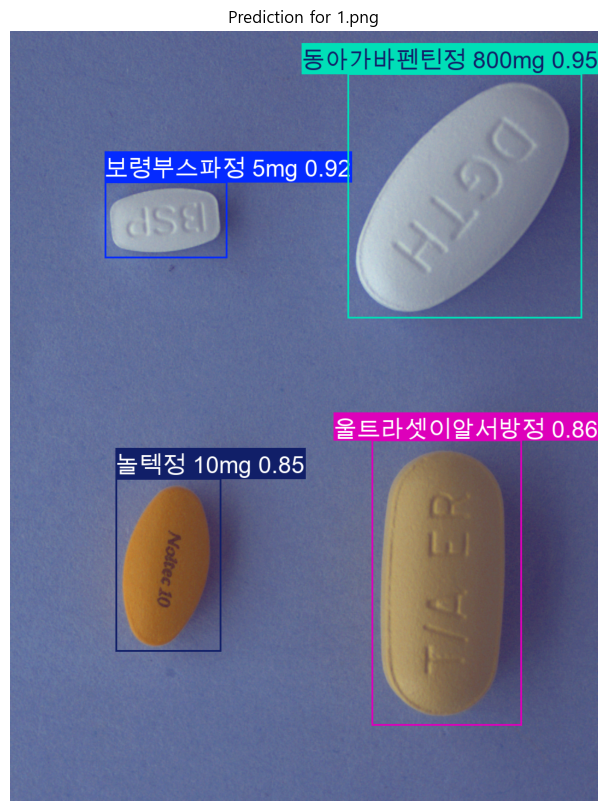

First image's detections:
  - Class: 동아가바펜틴정 800mg (YOLO ID: 23), Conf: 0.95, Bbox (norm xywh): [0.7734133005142212, 0.21400824189186096, 0.3990876078605652, 0.31789737939834595]
  - Class: 보령부스파정 5mg (YOLO ID: 0), Conf: 0.92, Bbox (norm xywh): [0.26536065340042114, 0.24543844163417816, 0.20742571353912354, 0.09874410927295685]
  - Class: 울트라셋이알서방정 (YOLO ID: 51), Conf: 0.86, Bbox (norm xywh): [0.742484450340271, 0.7165263295173645, 0.25480926036834717, 0.37158986926078796]
  - Class: 놀텍정 10mg (YOLO ID: 44), Conf: 0.85, Bbox (norm xywh): [0.2698337137699127, 0.6931304335594177, 0.17953552305698395, 0.2248700112104416]


In [31]:
# 추론 결과 시각화 예시
# inference_results는 Results 객체
if inference_results:
    print("Displaying first inference result (if available)...")
    first_result = inference_results[0]
    im_bgr = first_result.plot() # BGR 이미지 (OpenCV 형식)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB) # RGB로 변환 (matplotlib용)

    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.title(f"Prediction for {Path(first_result.path).name}")
    plt.axis('off')
    plt.show()

    # 바운딩 박스 정보 출력 예시
    print("First image's detections:")
    for box_data in first_result.boxes:
        cls = int(box_data.cls)
        conf = float(box_data.conf)
        xywh_norm = box_data.xywhn[0].tolist() # 정규화된 xywh

        # YOLO 클래스 ID를 실제 카테고리 이름으로 변환
        class_name = yolo_idx_to_name_map.get(cls, f"Unknown_{cls}")
        print(f"  - Class: {class_name} (YOLO ID: {cls}), Conf: {conf:.2f}, Bbox (norm xywh): {xywh_norm}")

In [32]:
# ====================================================================
# 임시 파일 삭제
# ====================================================================
shutil.rmtree(YOLO_LABELS_TEMP)
print(f"Removed temporary YOLO label directory: {YOLO_LABELS_TEMP}")

Removed temporary YOLO label directory: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp
